# RLbook2020-2.7 UCB

仿真UCB算法的性能


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import utilities as util
#%load_ext autoreload
#%autoreload 2


In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\chenxy\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_tes

## 函数改造

基于RLbook-2.6-Optimistic-initial-value中的k_armed_bandit_one_run()进行改造。

(1) 追加一个参数actsel用于指定行动选择算法，缺省设置为None时表示epsilon-greedy
(2) 在采用UCB算法时，epsilon参数用作UCB算法中的控制参数c

In [7]:
print(-10000 > -np.Inf)
print(np.log(2.78))

True
1.0224509277025455


In [6]:
def k_armed_bandit_one_run(qstar,epsilon,nStep,Qinit,QUpdtAlgo='sample_average',alpha=0, stationary=True, actsel=None):
    """
    One run of K-armed bandit simulation.
    Add Qinit to the interface.
    Input:
        qstar:     Mean reward for each candition actions
        epsilon:   Epsilon value for epsilon-greedy algorithm
        nStep:     The number of steps for simulation
        Qinit:     Initial setting for action-value estimate
        QUpdtAlgo: The algorithm for updating Q value--'sample_average','exp_decaying'
        alpha:     step-size in case of 'exp_decaying'
        actsel:    Specifying action selection algorithm
    Output:
        a[t]: action series for each step in one run
        r[t]: reward series for each step in one run
        Q[k]: reward sample average up to t-1 for action[k]
        aNum[k]: The number of being selected for action[k]
        optRatio[t]: Ration of optimal action being selected over tim
    """
    
    #print('QUpdtAlgo=',QUpdtAlgo)
    #print('Qinit=',Qinit)
    #print('actsel=',actsel)
    #print('qstar=',qstar)
    #print('epsilon=',epsilon)
            
    K     = len(qstar)
    Q     = Qinit
    a     = np.zeros(nStep+1,dtype='int') # Item#0 for initialization
    aNum  = np.zeros(K,dtype='int')       # Record the number of action#k being selected
    
    r     = np.zeros(nStep+1)             # Item#0 for initialization

    if stationary == False:
        qstar = np.ones(K)/K                 # qstart initialized to 1/K for all K actions    
    
    optCnt   = 0
    optRatio = np.zeros(nStep+1,dtype='float') # Item#0 for initialization

    for t in range(1,nStep+1):

        #0. For non-stationary environment, optAct also changes over time.Hence, move to inside the loop.
        optAct   = np.argmax(qstar)
                
        #1. action selection
        if actsel == 'UCB':
            aMax = -np.Inf            
            for k in range(K):
                if aNum[k] == 0:
                    aMetric = np.inf
                else:
                    aMetric = Q[k] + epsilon * np.sqrt(np.log(t)/aNum[k])
                if aMax < aMetric:
                    aOpt = k
                    aMax = aMetric
            a[t] = aOpt                                
        else:
            tmp = np.random.uniform(0,1)
            if tmp < epsilon: # random selection
                a[t] = np.random.choice(np.arange(K))
                #print('random selection: a[{0}] = {1}'.format(t,a[t]))
            else:             # greedy selection
                #选择Q值最大的那个，当多个Q值并列第一时，从中任选一个--但是如何判断有多个并列第一的呢？
                #对Q进行random permutation处理后再找最大值可以等价地解决这个问题
                p = np.random.permutation(K)
                a[t] = p[np.argmax(Q[p])]
                #print('greedy selection: a[{0}] = {1}'.format(t,a[t]))

        aNum[a[t]] = aNum[a[t]] + 1

        #2. reward: draw from the pre-defined probability distribution    
        r[t] = np.random.randn() + qstar[a[t]]        

        #3.Update Q of the selected action - #2.4 Incremental Implementation
        # Q[a[t]] = (Q[a[t]]*(aNum[a[t]]-1) + r[t])/aNum[a[t]]    
        if QUpdtAlgo == 'sample_average':
            Q[a[t]] = Q[a[t]] + (r[t]-Q[a[t]])/aNum[a[t]]    
        elif QUpdtAlgo == 'exp_decaying':
            Q[a[t]] = Q[a[t]] + (r[t]-Q[a[t]])*alpha
        
        #4. Optimal Action Ratio tracking
        #print(a[t], optAct)
        if a[t] == optAct:
            optCnt = optCnt + 1
        optRatio[t] = optCnt/t

        #5. Random walk of qstar simulating non-stationary environment
        # Take independent random walks (say by adding a normally distributed increment with mean 0
        # and standard deviation 0.01 to all the q⇤(a) on each step).   
        if stationary == False:        
            qstar = qstar + np.random.randn(K)*0.01 # Standard Deviation = 0.01
            #print('t={0}, qstar={1}, sum={2}'.format(t,qstar,np.sum(qstar)))
        
    return a,aNum,r,Q,optRatio

## Experiment with epsilon-greedy action selection as regression test


(1) Action selction: epsilon-greedy with epsilon=0.1

(2) Q estimation method: sample-average method

(3) Environment: stationary

Text(0.5, 1.0, 'qstar vs aNum')

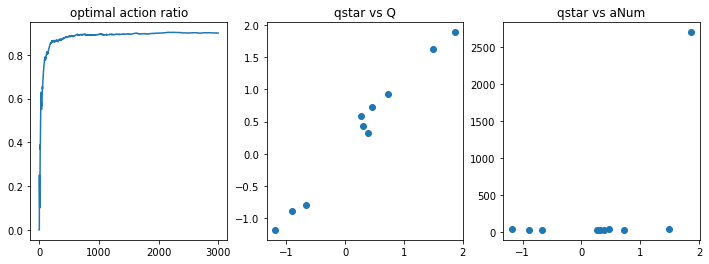

In [7]:
nStep = 3000
epsilon = 0.1
K       = 10
qstar   = np.random.randn(K)
Qinit   = np.zeros(K)
a,aNum,r,Q,optRatio = k_armed_bandit_one_run(qstar,epsilon,nStep, Qinit=np.ones(K)*5)
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(optRatio)
ax[1].scatter(qstar,Q)
ax[2].scatter(qstar,aNum)
ax[0].set_title('optimal action ratio')
ax[1].set_title('qstar vs Q')
ax[2].set_title('qstar vs aNum')

## Experiment with UCB action selection

(1) Action selction: UCB

(2) Q estimation method: sample-average method

(3) Environment: stationary


[-0.52225457  0.02220162  1.30726853 -1.10416326 -0.09560486  0.60417317
  0.09218303 -1.72606979 -1.26303783  0.13614243] 2


Text(0.5, 1.0, 'qstar vs aNum')

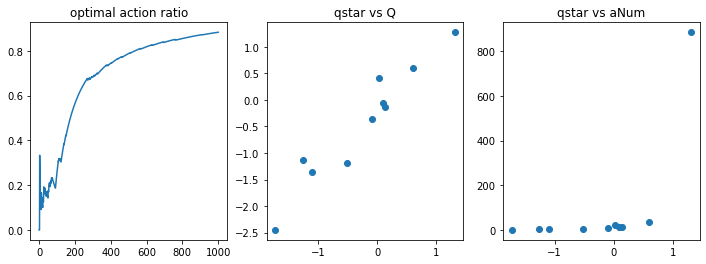

In [8]:
nStep = 1000
epsilon = 2
K       = 10
qstar   = np.random.randn(K)
Qinit   = np.zeros(K)
print(qstar, np.argmax(qstar))
a,aNum,r,Q,optRatio = k_armed_bandit_one_run(qstar,epsilon,nStep, Qinit, actsel='UCB')
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].plot(optRatio)
ax[1].scatter(qstar,Q)
ax[2].scatter(qstar,aNum)
ax[0].set_title('optimal action ratio')
ax[1].set_title('qstar vs Q')
ax[2].set_title('qstar vs aNum')

In [8]:
print(aNum)
print(qstar)

[  1   1   1   1   1   1   1   1   1 991]
[ 1.31145117  0.383859   -1.40324447 -0.189382   -2.28145394 -0.93950005
 -1.07787184  0.19357217 -0.5169025   0.87406999]


## 仿真对比Epsilon-greedy方法和UCB方法

In [11]:
nStep = 1000
nRun  = 2000
K     = 10

r_1   = np.zeros((nRun,nStep+1))
r_2   = np.zeros((nRun,nStep+1))
optRatio_1 = np.zeros((nRun,nStep+1))
optRatio_2 = np.zeros((nRun,nStep+1))

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(10)     
    a,aNum,r_1[run,:],Q,optRatio_1[run,:] = k_armed_bandit_one_run(qstar,epsilon=0.1,nStep=nStep,Qinit=np.zeros(K),actsel=None)
    a,aNum,r_2[run,:],Q,optRatio_2[run,:] = k_armed_bandit_one_run(qstar,epsilon=2,nStep=nStep,Qinit=np.zeros(K),actsel='UCB')


....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

In [17]:
nStep = 1000
nRun  = 2000
K     = 10

r_3   = np.zeros((nRun,nStep+1))
optRatio_3 = np.zeros((nRun,nStep+1))

for run in range(nRun):
    print('.',end='')
    if run%100==99:        
        print('run = ',run+1)
    
    qstar   = np.random.randn(10)     
    a,aNum,r_3[run,:],Q,optRatio_3[run,:] = k_armed_bandit_one_run(qstar,epsilon=3,nStep=nStep,Qinit=np.zeros(K),actsel='UCB')


....................................................................................................run =  100
....................................................................................................run =  200
....................................................................................................run =  300
....................................................................................................run =  400
....................................................................................................run =  500
....................................................................................................run =  600
....................................................................................................run =  700
....................................................................................................run =  800
....................................................................................................run =  900
.

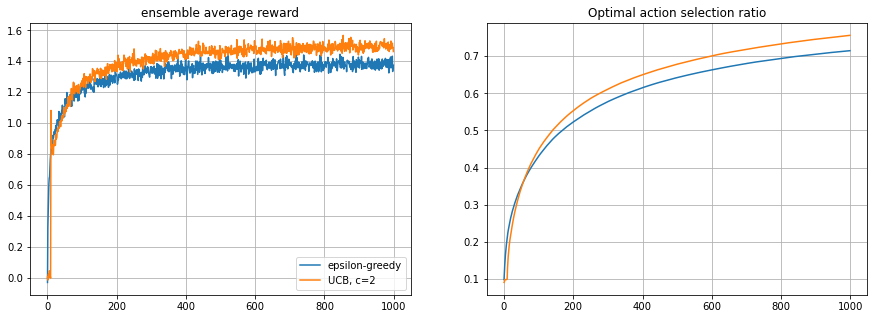

In [27]:
rEnsembleMean_greedy = np.mean(r_1,axis=0)
rEnsembleMean_ucb = np.mean(r_2,axis=0)
#rEnsembleMean_ucb_c3 = np.mean(r_3,axis=0)

optRatioEnsembleMean_greedy = np.mean(optRatio_1,axis=0)
optRatioEnsembleMean_ucb = np.mean(optRatio_2,axis=0)
#optRatioEnsembleMean_ucb_c3 = np.mean(optRatio_3,axis=0)

fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(rEnsembleMean_greedy[1:])  # Note: t count from 1 in k_armed_bandit_one_run()
ax[0].plot(rEnsembleMean_ucb[1:])
#ax[0].plot(rEnsembleMean_ucb_c3[1:])
#ax[0].legend(['epsilon-greedy','UCB, c=2','UCB, c=3'])
ax[0].legend(['epsilon-greedy','UCB, c=2'])
ax[0].set_title('ensemble average reward')
ax[0].grid()

ax[1].plot(optRatioEnsembleMean_greedy[1:])
ax[1].plot(optRatioEnsembleMean_ucb[1:])
#ax[1].plot(optRatioEnsembleMean_ucb_c3[1:])
#ax[1].legend(['epsilon-greedy','UCB, c=2','UCB, c=3'])
ax[0].legend(['epsilon-greedy','UCB, c=2'])
ax[1].set_title('Optimal action selection ratio')
ax[1].grid()


In [26]:
print(rEnsembleMean_ucb[1:20])
print(rEnsembleMean_ucb_c3[1:20])

[ 2.99401618e-03 -1.59113891e-02  1.34047078e-02  2.44974318e-02
  7.11602049e-04  4.28279421e-02  4.37150286e-02  2.20117798e-02
  8.16120839e-03 -3.34637778e-03  1.08168623e+00  9.42364327e-01
  8.52690411e-01  8.39345439e-01  8.60943325e-01  8.14212276e-01
  7.97944830e-01  7.94554962e-01  8.55722112e-01]
[-3.01620054e-02 -1.18116766e-02  4.52133223e-03  2.79576493e-02
 -1.51886896e-02  6.69475064e-04  8.51980411e-03  7.85338515e-02
 -4.16175580e-02 -1.29349685e-02  1.10140771e+00  8.65980125e-01
  7.14872248e-01  5.90266224e-01  5.35638297e-01  5.48086381e-01
  5.69206598e-01  5.18802599e-01  5.22265854e-01]
